# Text Mining using NLTK
This notebook contains six sub tasks and an additional bonus task 
1.   Age and text demographics
2.   Extracted features visualization (frequency and overlap of words)
3.   Age bins, clustering and summarization techniques
4.   Logistic classfier on extracted feature dataset
5.   Results (in terms of accuracy and confusion matrix)
6.   Training on more complex classifier (random forest classification)


Additional tasks - Exploring NLTK library and pre-processing the untagged subcorpora

In [ ]:
!pip install altair
!pip install lxml
!pip install sentencepiece
!pip install transformers

In [ ]:
import os
import random
from collections import defaultdict, Counter
from pprint import pprint
import numpy as np
import pandas as pd
from lxml import etree
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import math
import xml.etree.ElementTree as ET
import nltk
import torch
import transformers



In [ ]:
# Mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Before we tackle the individual tasks, required libraries such as os, pandas, numpy, altair, matplotlib,
lxml are imported for visualization and parsing XML files.
The paths to the tagged and untagged directories of the corpus are defined and lists of file paths are
created, to read the XML files (read_xml() function) and store the required features in data frames.


The speakers metadata is stored in the dataframe – speakers

The texts metadata is stored in the dataframe – texts

In [ ]:
# tagged directory included words with POS tagging; whereas untagged directory does not have POS tagging.
# change to your directory path
path = '/content/drive/MyDrive/bnc2014spoken-xml' # change this to be your own path
dir_tagged_corpus = path + '/spoken/tagged/'
dir_untagged_corpus = path + '/spoken/untagged/'
dir_meta = path + '/spoken/metadata/'

In [ ]:
f_tagged_names = os.listdir(dir_tagged_corpus)
f_tagged_paths = [f"{dir_tagged_corpus}{f_name}" for f_name in f_tagged_names]

In [ ]:
f_untagged_names = os.listdir(dir_untagged_corpus)
f_untagged_paths = [f"{dir_untagged_corpus}{f_name}" for f_name in f_untagged_names]

In [ ]:
def get_xml(f_path):
    with open(f_path, 'r') as f:
        f = f.read()
    xml = etree.fromstring(f)
    return xml
for path in f_tagged_paths: # for each of the dialogues
    df_utts = pd.read_xml(path, xpath="//u") 
    break  
   

In [ ]:
%%time
texts = []
for f_path in f_tagged_paths:
    xml = get_xml(f_path)
    id = xml.get('id')
    texts.append(id)

CPU times: user 43.5 s, sys: 1.64 s, total: 45.1 s
Wall time: 1min 35s


In [ ]:
speakers_words = defaultdict(int)
for f_path in f_tagged_paths:
    xml = get_xml(f_path)
    for u in xml.iter('u'):
        speaker = u.get('who')
        n_words = len([w for w in u.iter('w')])
        speakers_words[speaker] += n_words
        
        
print(f'number of speakers: {len(speakers_words)}')

number of speakers: 671


In [ ]:
df_speakers_words = pd.DataFrame(list(speakers_words.items()), columns=['speaker', 'n_words'])

In [ ]:
df_speakers_words.sort_values('speaker', ascending=True, inplace=True)

In [ ]:
df_speakers_words
#write the above dataframe to csv if required
df_speakers_words.to_csv('/content/drive/MyDrive/bnc2014spoken-xml/outspeakers_nwords.csv')

In [ ]:
#No. of words in the corpus

n_words = 0
for f_path in f_tagged_paths:
    xml = get_xml(f_path)
    for w in xml.iter('w'):
        n_words += 1
        
print(f'total number of words in the corpus: {n_words}')

total number of words in the corpus: 11422615


In [ ]:
# =loading speakers txt file
head_speakers = pd.read_csv(
    f"{dir_meta}metadata-fields-speaker.txt",
    delimiter='\t',
    skiprows=1,
    index_col=0
)

In [ ]:
# loading speakerdata tsv file
speakers = pd.read_csv(
    f"{dir_meta}bnc2014spoken-speakerdata.tsv", 
    delimiter='\t', 
    names=head_speakers['XML tag'],
    index_col=0
)

In [ ]:
# Load text data

head_texts = pd.read_csv(
    f"{dir_meta}metadata-fields-text.txt",
    delimiter='\t',
    skiprows=1,
    index_col=0
)

In [ ]:
# Loading textdata from tsv file

texts = pd.read_csv(
    f"{dir_meta}bnc2014spoken-textdata.tsv", 
    delimiter='\t', 
    names=head_texts['XML tag'],
    index_col=0
)

### Statistics Summary and Texts summary
Age Statistics of this dataset are extracted, the  speaker’s age demographics in terms of mean values,
range, standard deviations, min/max values, median values and 25%/50%/75% percentile
valuess. 

In [ ]:
# Extract the exactage column from the DataFrame
exactage_col = speakers['exactage']

# Compute summary statistics
summary_stats1 = exactage_col.describe(percentiles=[0.25, 0.5, 0.75])

# Print the summary statistics
print(summary_stats1)

speakers['exactage'] = pd.to_numeric(speakers['exactage'], errors='coerce')

# Compute additional statistics
mean_age = speakers['exactage'].mean()
min_age = speakers['exactage'].min()
max_age = speakers['exactage'].max()
age_range = max_age - min_age
std_dev = speakers['exactage'].std()
p25 = speakers['exactage'].quantile(0.25)
p50 = speakers['exactage'].quantile(0.50)
p75 = speakers['exactage'].quantile(0.75)

# Create summary statistics dataframe
summary_stats = pd.DataFrame({
    'mean age': mean_age,
    'min age': min_age,
    'max age': max_age,
    'age range': age_range,
    'std dev': std_dev,
    '25% percentile': p25,
    '50% percentile': p50,
    '75% percentile': p75
}, index=['exactage'])



summary_stats


count     529
unique     85
top        20
freq       32
Name: exactage, dtype: object


,mean age,min age,max age,age range,std dev,25% percentile,50% percentile,75% percentile
exactage,39.893939,2.0,91.0,89.0,20.159236,22.0,34.0,55.25


Age statistics with respect to gender, socio-economic grade, and birthplace

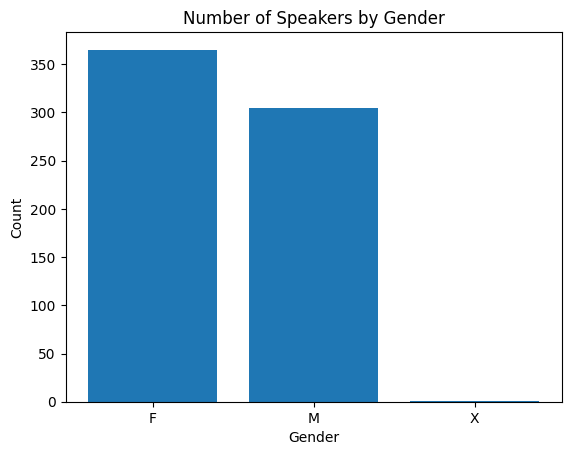

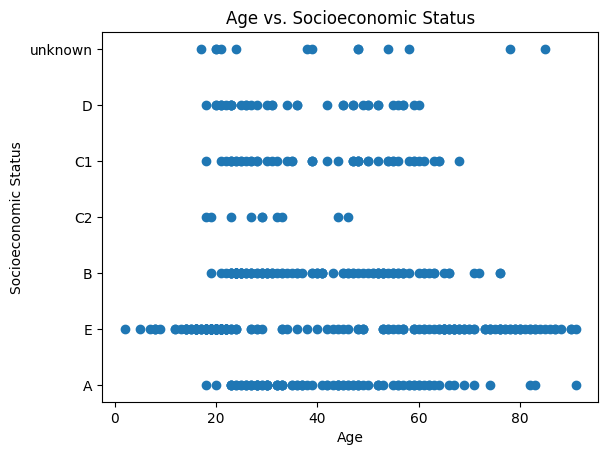

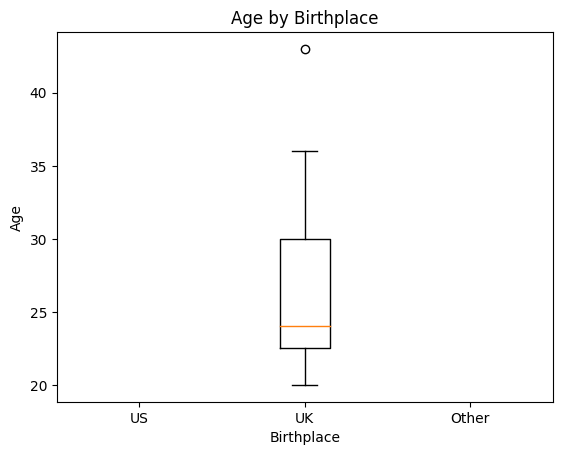

In [ ]:
# Compute age statistics with respect to gender, socio-economic grade, and birthplace
age_stats = speakers['exactage'].describe()

# Convert exact age column to numeric and create a DataFrame for age, gender, socio-economic grade, and birthplace
speakers['exactage'] = pd.to_numeric(speakers['exactage'], errors='coerce')
age_gender_grade_place_df = speakers[['exactage', 'gender', 'socgrade', 'birthplace']]

# Graph 1: Bar chart of number of speakers by gender
gender_counts = age_gender_grade_place_df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.title("Number of Speakers by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Graph 2: Scatter plot of age versus socioeconomic status
age_ses_df = age_gender_grade_place_df.dropna(subset=['exactage', 'socgrade'])
plt.scatter(age_ses_df['exactage'], age_ses_df['socgrade'])
plt.title("Age vs. Socioeconomic Status")
plt.xlabel("Age")
plt.ylabel("Socioeconomic Status")
plt.show()

# Graph 3: Box plot of age by birthplace
age_place_df = age_gender_grade_place_df.dropna(subset=['exactage', 'birthplace'])
plt.boxplot([age_place_df[age_place_df['birthplace'] == 'US']['exactage'], 
             age_place_df[age_place_df['birthplace'] == 'UK']['exactage'],
             age_place_df[age_place_df['birthplace'] == 'Other']['exactage']])
plt.title("Age by Birthplace")
plt.xlabel("Birthplace")
plt.ylabel("Age")
plt.xticks([1, 2, 3], ['US', 'UK', 'Other'])
plt.show()


In [ ]:
# Group speakers by gender and compute mean age
gender_mean_age = speakers.groupby('gender')['exactage'].mean()

# Group speakers by socio-economic grade and compute mean age
socio_grade_mean_age = speakers.groupby('socgrade')['exactage'].mean()

# Group speakers by birthplace and compute mean age
birthplace_mean_age = speakers.groupby('birthplace')['exactage'].mean()

# Report the mean age differences
print("Mean age differences:")
print(gender_mean_age)
print(socio_grade_mean_age)
print(birthplace_mean_age)


Mean age differences:
gender
F    38.619377
M    41.435146
X          NaN
Name: exactage, dtype: float64
socgrade
A          42.747253
B          39.657407
C1         41.580000
C2         30.000000
D          36.526316
E          39.330275
unknown    42.307692
Name: exactage, dtype: float64
birthplace
Abergavenny                     28.000000
Aberystwyth                     20.000000
Aldershot, Hampshire            49.333333
Almondsbury, Gloucestershire    62.000000
Ascot                           16.000000
                                  ...    
Wordsley, West Midlands         32.000000
Wrexham                         20.000000
Yeovil                          48.000000
Yoevil                          28.000000
York                            23.500000
Name: exactage, Length: 323, dtype: float64


#### Statistics of the text data in utterance text -

This code creates a dictionary of speaker data by iterating through dialogues and calculating the
average length of each speaker's utterances. It then converts the dictionary to a DataFrame and saves it
to a CSV file.
Next, it converts the 'exactage' column in the 'speakers' DataFrame to numeric and creates a color map
for age groups based on the 'exactage' column. Finally, it creates a scatter plot of the number of
utterances versus age, where each point is colored based on the speaker's age group.

In [ ]:
# Create an empty dictionary to store speaker data
speaker_data = {}

# Iterate through the dialogues
for path in f_untagged_paths:
    df_utts = pd.read_xml(path, xpath="//u")
    df_speakers = pd.read_xml(path, xpath="//speaker")
    # Calculate the average utterance length per speaker
    utt_len = df_utts['u'].str.len().groupby(df_utts['who']).mean()
    # Append speaker data to dictionary
    speaker_data.update(utt_len.to_dict())

# Create a DataFrame from the dictionary of speaker data
speaker_utt_df = pd.DataFrame.from_dict(speaker_data, orient='index', columns=['n_utterances'])
speaker_utt_df.index.name = 'speaker'
print(speaker_utt_df)
speaker_utt_df.to_csv('/content/drive/MyDrive/bnc2014spoken-xml/uttspeakers_nwords.csv')


           n_utterances
speaker                
S0255         26.436364
S0259         26.953782
UNKFEMALE      2.625000
S0041         26.899396
S0046         23.894309
...                 ...
S0101         20.600000
S0102         20.465116
S0117         19.793651
S0156         14.181818
S0345         32.729839

[671 rows x 1 columns]


In [ ]:
# A code snippet to get number of speakers per dialogue

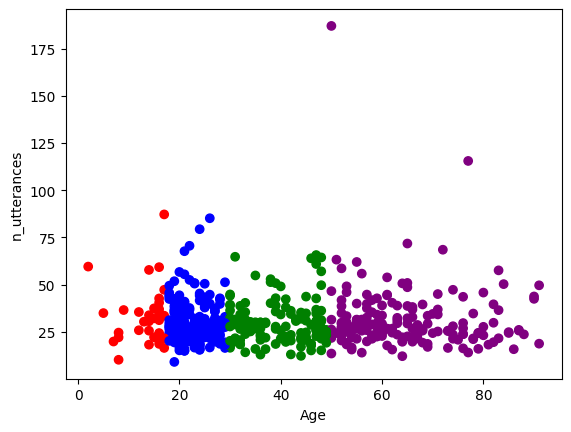

In [ ]:
speakers['exactage'] = pd.to_numeric(speakers['exactage'], errors='coerce')
# Create a color map for age groups
age_groups = pd.cut(speakers['exactage'], [0, 18, 30, 50, 100], include_lowest=True, right=False, labels=['0-18', '18-30', '30-50', '50+'])
colors = {'0-18': 'red', '18-30': 'blue', '30-50': 'green', '50+': 'purple'}
age_groups = age_groups.cat.add_categories(['black']) # Add 'black' as a category
speakers['color'] = age_groups.map(colors).fillna('black')

# Plot the scatter plot
plt.scatter(speakers['exactage'], speaker_utt_df['n_utterances'], c=speakers['color'])
plt.xlabel('Age')
plt.ylabel('n_utterances')
plt.show()


### Data Visualization
For Data visualization, we extract few other additional insights and plot them as follows:

1.   Frequency of words from tagged files, age groups 
2.   Vocabulary overlap frequency 






In [ ]:
# Define the directory containing the tagged XML files
dir_path = "/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged"

# Get a list of all the tagged XML files in the directory
f_tagged_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".xml")]

# Define the user tags we're interested in (replace with actual tags from data)


# Loop over each tagged XML file
word_freqs = Counter()
for f_path in f_tagged_paths[:5]:
    xml = ET.parse(f_path).getroot()
    print(f_path)
    for u in xml.iter('u'):
        speaker = u.get('who')
        words = [w.text for w in u.iter('w')]
        word_freqs.update(words)

# Print the 10 most common words and their frequencies
for word, freq in word_freqs.most_common(10):
    print(f"{word}: {freq}")

      

            
        
        
          




/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7KK-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7QU-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7NH-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7NJ-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7KD-tgd.xml
I: 2211
it: 1811
you: 1596
's: 1518
the: 1465
and: 1399
to: 1047
that: 1047
a: 949
?: 937


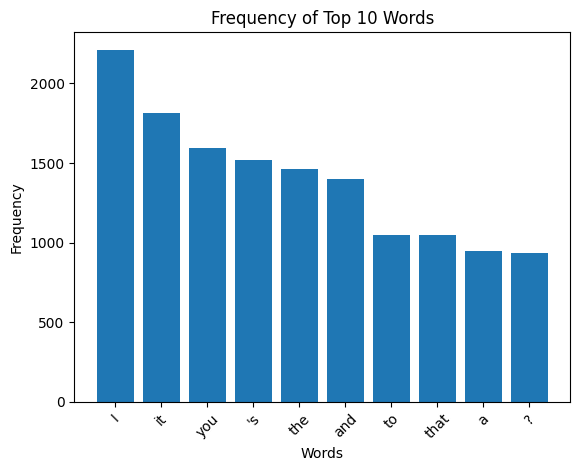

In [ ]:

# Get the top 10 most common words and their frequencies
top_words = [word for word, _ in word_freqs.most_common(10)]
word_counts = [count for _, count in word_freqs.most_common(10)]

# Create a bar chart of the word frequencies
plt.bar(top_words, word_counts)

# Set the title and axis labels
plt.title("Frequency of Top 10 Words")
plt.xlabel("Words")
plt.ylabel("Frequency")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:

# Define the directory containing the tagged XML files
dir_path = "/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged"

# Get a list of all the tagged XML files in the directory
f_tagged_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".xml")]

# Loop over each tagged XML file and extract the words and their frequency for each speaker
all_word_freqs = Counter()
for f_path in f_tagged_paths[:5]:
    xml = ET.parse(f_path).getroot()
    print(f_path)
    for u in xml.iter('u'):
        speaker = u.get('who')
        words = [w.text for w in u.iter('w')]
        speaker_word_freqs = Counter(words)
        for word, freq in speaker_word_freqs.items():
            all_word_freqs[(speaker, word)] += freq

# Create a DataFrame with speaker, word, and frequency columns
df = pd.DataFrame.from_dict(all_word_freqs, orient='index', columns=['frequency'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['speaker', 'word'])
df.reset_index(inplace=True)

# Add the age column to the DataFrame
# Assume `df` and `speakers` dataframes are already defined
merged_df= pd.merge(df, speakers[['exactage']], left_on='speaker', right_index=True)

merged_df['exactage'] = pd.to_numeric(merged_df['exactage'], errors='coerce')
merged_df['age_group'] = merged_df['exactage'].apply(lambda age: 'old' if age >= 50 else 'young')

word_freqs = merged_df.groupby(['word', 'age_group'])['frequency'].sum().reset_index()
# Get the top 10 words for each age group
top_words = word_freqs.groupby('age_group').apply(lambda x: x.nlargest(10, 'frequency'))

# Plot the graph
sns.barplot(x='word', y='frequency', hue='age_group', data=top_words)


In [ ]:

nltk.download('stopwords')

# Define the directory containing the tagged XML files
dir_path = "/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged"

# Get a list of all the tagged XML files in the directory
f_tagged_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".xml")]

# Define the user tags we're interested in (replace with actual tags from data)

# Define stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('not') # if needed, we can remove 'not' from the list of stopwords

# Loop over each tagged XML file
word_freqs = Counter()
for f_path in f_tagged_paths[:5]:
    xml = ET.parse(f_path).getroot()
    print(f_path)
    for u in xml.iter('u'):
        speaker = u.get('who')
        words = [w.text for w in u.iter('w') if w.text.lower() not in stopwords]
        word_freqs.update(words)

# Print the 10 most common words and their frequencies
for word, freq in word_freqs.most_common(10):
    print(f"{word}: {freq}")
# Create a DataFrame with speaker, word, and frequency columns
df = pd.DataFrame.from_dict(all_word_freqs, orient='index', columns=['frequency'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['speaker', 'word'])
df.reset_index(inplace=True)

# Add the age column to the DataFrame
# Assume `df` and `speakers` dataframes are already defined
merged_df= pd.merge(df, speakers[['exactage']], left_on='speaker', right_index=True)




/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7KK-tgd.xml


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7QU-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7NH-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7NJ-tgd.xml
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7KD-tgd.xml
's: 1518
?: 937
n't: 888
yeah: 885
mm: 710
know: 464
well: 405
like: 359
think: 357
oh: 317


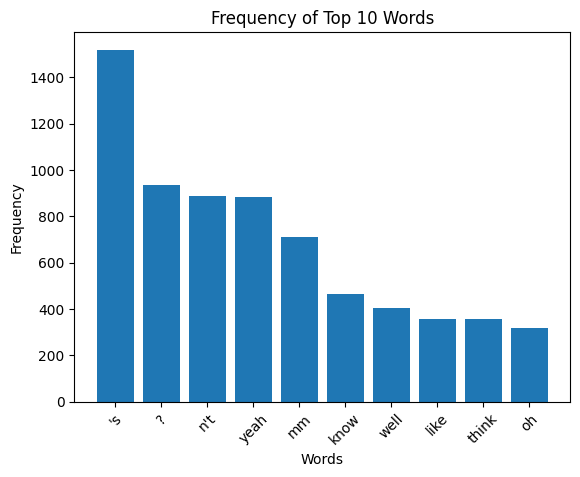

In [ ]:

# Get the top 10 most common words and their frequencies
top_words = [word for word, _ in word_freqs.most_common(10)]
word_counts = [count for _, count in word_freqs.most_common(10)]

# Create a bar chart of the word frequencies
plt.bar(top_words, word_counts)

# Set the title and axis labels
plt.title("Frequency of Top 10 Words")
plt.xlabel("Words")
plt.ylabel("Frequency")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


### Vocabulary overlap between two speakers - 
 It calculates the vocabulary statistics for each age group, including the number of unique words spoken
by young speakers, the number of unique words spoken by old speakers, and the number of words
spoken by both young and old speakers.

In [ ]:
# initialize a dictionary to store words spoken by each speaker
speaker_words = {}

# loop through each dialogue
for f_path in f_tagged_paths[:5]:
    # get the xml data for the dialogue
    xml = get_xml(f_path)    
    # loop through each utterance in the dialogue
    for u in xml.iter('u'):
        # get the speaker
        speaker = u.get('who')
        # loop through each word in the utterance
        for w in u.iter('w'):
            # add the word to the appropriate set based on the speaker
            speaker_words.setdefault(speaker, {'words': set()}).get('words').add(w.text)
            
# check if there is any overlap between the sets of words spoken by each speaker
speakers_list = list(speaker_words.keys())
if len(speakers_list) > 1:
    overlap = set(speaker_words[speakers_list[0]]['words'])
    for speaker in speakers_list[1:]:
        overlap = overlap.intersection(speaker_words[speaker]['words'])
    if len(overlap) > 0:
        print('There is vocabulary overlap between the speakers.')
    else:
        print('There is no vocabulary overlap between the speakers.')
else:
    print('This dialogue does not have more than 1 speaker.')


# merge the speaker_words dictionary with the speakers dataframe
df = pd.DataFrame.from_dict(speaker_words, orient='index', columns=['words'])
df.index.name = 'speaker'

speakers['exactage'] = pd.to_numeric(speakers['exactage'], errors='coerce')
# Create a color map for age groups
age_groups = pd.cut(speakers['exactage'], [0, 18, 30, 50, 100], include_lowest=True, right=False, labels=['0-18', '18-30', '30-50', '50+'])


#merged_df = pd.merge(df, speakers_df, on='speaker')
merged_df = pd.merge(df, speakers[['exactage']], left_on='speaker', right_index=True, how='inner')
print(merged_df)
# group speakers by age into two categories: young (age < 50) and old (age >= 50)
merged_df['exactage'] = pd.to_numeric(merged_df['exactage'], errors='coerce')
merged_df['age_group'] = merged_df['exactage'].apply(lambda age: 'young' if age < 50 else 'old')

# calculate the vocabulary statistics for each age group
young_words = set()
old_words = set()
for _, row in merged_df.iterrows():
    if row['age_group'] == 'young':
        young_words.update(row['words'])
    else:
        old_words.update(row['words'])
overlap = young_words.intersection(old_words)
unique_young_words = young_words.difference(overlap)
unique_old_words = old_words.difference(overlap)

print(f'Number of unique words spoken by young speakers: {len(unique_young_words)}')
print(f'Number of unique words spoken by old speakers: {len(unique_old_words)}')
print(f'Number of words spoken by both young and old speakers: {len(overlap)}')


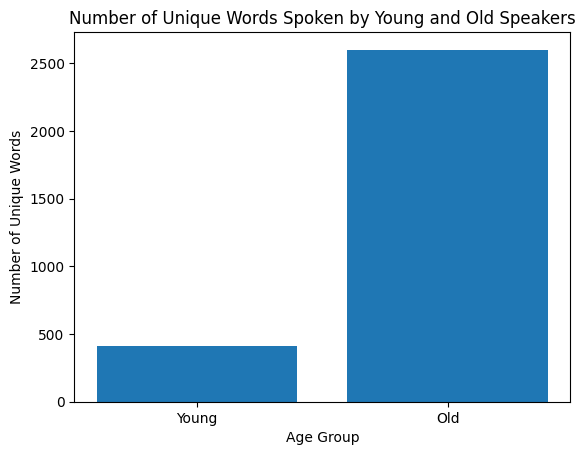

In [ ]:
import matplotlib.pyplot as plt

# create a bar plot
plt.bar(['Young', 'Old'], [len(unique_young_words), len(unique_old_words)])
plt.title('Number of Unique Words Spoken by Young and Old Speakers')
plt.xlabel('Age Group')
plt.ylabel('Number of Unique Words')
plt.show()


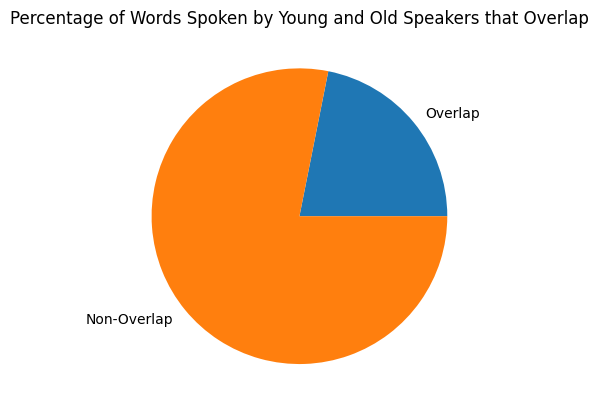

In [ ]:
# calculate the percentage of words that overlap
percent_overlap = len(overlap) / (len(unique_young_words) + len(unique_old_words) + len(overlap)) * 100

# create a pie chart
plt.pie([percent_overlap, 100-percent_overlap], labels=['Overlap', 'Non-Overlap'])
plt.title('Percentage of Words Spoken by Young and Old Speakers that Overlap')
plt.show()


### Age – bins creation

The age bins code creates age range categories from the 'exactage' column in the 'speakers' dataframe
using the `pd.cut()` method. The `bins` variable defines the bin edges as 10 evenly spaced values
between the minimum and maximum ages in the 'exactage' column.

In [ ]:

# create age-range bins
bins = np.linspace(min(speakers['exactage']), max(speakers['exactage']), 11)
bins = np.insert(bins, 0, -1., axis=0)

# add a new column to the speakers dataframe with the bin labels
speakers['age_bin'] = pd.cut(speakers['exactage'], bins=bins, labels=[f"{int(bins[i])+1}-{int(bins[i+1])}" for i in range(len(bins)-1)])

# count the number of speakers in each age group
speakers_summary = speakers.groupby('age_bin').agg({'exactage': 'count'})

# print the summary
print(speakers_summary)


         exactage
age_bin          
0-2             1
3-10            6
11-19          56
20-28         157
29-37          62
38-46          47
47-55          67
56-64          55
65-73          37
74-82          26
83-91          14


In [ ]:
# count the number of texts in each number of speakers category
texts_summary = texts.groupby('n_speakers').agg({'rec_length': 'count'})

# print the summary
print(texts_summary)


            rec_length
n_speakers            
2                  622
3                  335
4                  198
5                   54
6                   25
7                   11
8                    2
9                    3
12                   1


#### Topics summaries
The code above extracts insights on summaries of topics in dialogues between younger and older
speakers. 

In [ ]:
# split the list of speakers into individual speaker names
speakers_topics = texts['list_speakers'].str.split(expand=True).stack().reset_index(level=1, drop=True).rename('speaker')

# split the topics by comma and create a new row for each topic-speaker combination
topics = texts['topics'].str.split(', ').explode().reset_index(drop=True)
speakers_topics = speakers_topics.reset_index(drop=True)
topics = topics.reset_index(drop=True)


# create a new dataframe by merging the speakers and topics dataframes
df_speakers_topics = pd.concat([speakers_topics, topics], axis=1)

# group the dataframe by speaker names and aggregate their topics into a list
df_speakers_topics = df_speakers_topics.groupby('speaker')['topics'].agg(list).reset_index()
print(df_speakers_topics.head())
print(len(df_speakers_topics))

  speaker                                             topics
0   S0001                                 [Pulling crackers]
1   S0002                           [racism/races and crime]
2   S0003                                         [drinking]
3   S0004  [beans and asparagus, deliberately failing 11+...
4   S0005                                            [Music]
667


In [ ]:
merged_topics_df = pd.merge(df_speakers_topics, speakers[['exactage']], left_on='speaker', right_index=True, how='inner')
merged_topics_df['exactage'] = pd.to_numeric(merged_topics_df['exactage'], errors='coerce')
bins = [0, 18, 35, 50, 65, np.inf]
labels = ['<18', '18-35', '35-50', '50-65', '65+']
merged_topics_df['age_group'] = pd.cut(merged_topics_df['exactage'], bins=bins, labels=labels, right=False)

In [ ]:
topic_counts = merged_topics_df.groupby('age_group')['topics'].apply(lambda x: pd.Series(x.sum()).value_counts())

In [ ]:
print(topic_counts)
topic_counts.to_csv('/content/drive/MyDrive/bnc2014spoken-xml/topic_counts.txt', sep='\t')
df_topic_counts = pd.DataFrame(topic_counts, columns=['count'])
df_topic_counts.to_excel('/content/drive/MyDrive/bnc2014spoken-xml/topic_counts.xlsx', index=True)


age_group                           
<18        food                         8
           work                         8
           family                       5
           weather                      4
           cooking                      4
                                       ..
65+        the flooding in Lancaster    1
           golf                         1
           health                       1
           Family                       1
           furniture in rooms           1
Name: topics, Length: 2639, dtype: int64


### Clustering the topic statistics using KMeans

By splitting the
speakers' names and topics into separate dataframes and then merges them together. The resulting
dataframe is grouped by speaker names, aggregating their topics into lists. The age information is
merged and processed, converting it to numeric and creating age groups. Next, the topics are
vectorized using TF-IDF, and K-means clustering is applied with five clusters. Finally, the cluster
labels are added to the dataframe for further analysis or visualization.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
# Split the list of speakers into individual speaker names
speakers_topics = texts['list_speakers'].str.split(expand=True).stack().reset_index(level=1, drop=True).rename('speaker')

# Split the topics by comma and create a new row for each topic-speaker combination
topics = texts['topics'].str.split(', ').explode().reset_index(drop=True)
speakers_topics = speakers_topics.reset_index(drop=True)
topics = topics.reset_index(drop=True)

# Create a new dataframe by merging the speakers and topics dataframes
df_speakers_topics = pd.concat([speakers_topics, topics], axis=1)

# Group the dataframe by speaker names and aggregate their topics into a list
df_speakers_topics = df_speakers_topics.groupby('speaker')['topics'].agg(list).reset_index()

merged_topics_df_Kmeans = pd.merge(df_speakers_topics, speakers[['exactage']], left_on='speaker', right_index=True, how='inner')
merged_topics_df_Kmeans['exactage'] = pd.to_numeric(merged_topics_df_Kmeans['exactage'], errors='coerce')
merged_topics_df_Kmeans.dropna(inplace=True)

bins = [0, 18, 35, 50, 65, np.inf]
labels = ['<18', '18-35', '35-50', '50-65', '65+']
merged_topics_df_Kmeans['age_group'] = pd.cut(merged_topics_df_Kmeans['exactage'], bins=bins, labels=labels, right=False)


# Convert exactage to string
merged_topics_df_Kmeans['exactage_str'] = merged_topics_df_Kmeans['exactage'].astype(str)

# Vectorize the topics using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(merged_topics_df_Kmeans['exactage_str'])

# Cluster the topics using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the grouped_df
merged_topics_df_Kmeans['cluster'] = kmeans.labels_

#### Summarization Techniques

Here we are extracting summaries from the tagged xml files in following ways and they are compared.

1.  Extarctive summary 
2.  Abstractive summary


In [ ]:
nltk.download('punkt')

# Define the directory containing the untagged XML files
dir_path = "/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged"

# Get a list of all the untagged XML files in the directory
f_tagged_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".xml")]
nltk.download('stopwords')
# Define the stop words
stop_words = set(stopwords.words('english'))

# Loop over each untagged XML file
for f_path in f_tagged_paths[:5]:
    xml = ET.parse(f_path).getroot()
    print(f_path)
    text = ""
    for u in xml.iter('u'):
        words = [w.text for w in u.iter('w') if w.text not in stop_words]
        text += " ".join(words) + " "
    
    # Split the text into sentences
    sentences = sent_tokenize(text)
    
    # Calculate the frequency of each word in the text
    word_freqs = Counter(text.split())
    
    # Calculate the importance of each sentence based on word frequency
    sentence_scores = {}
    for sentence in sentences:
        for word in nltk.word_tokenize(sentence.lower()):
            if word in word_freqs:
                if len(sentence.split()) < 30:
                    if sentence not in sentence_scores:
                        sentence_scores[sentence] = word_freqs[word]
                    else:
                        sentence_scores[sentence] += word_freqs[word]
    
    # Get the top 3 sentences with the highest scores and print them as a summary
    summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:3]
    summary = " ".join(summary_sentences)
    print("Summary:", summary)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7KK-tgd.xml
Summary: yeah doctor 's I n't understand doctors probably different kind doctors ca n't know n't got resources get allergy doctors people cos I 've mm mm n't allergies ? two onslaught well 's 's difficult enough fairly close together mm mm closer together mine mm girls yeah mm er two exactly 's going easy ? 's --ANONplace mm wealthy parents 're mm lunches mm poor fussy children mm n't cos n't like food ?
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7QU-tgd.xml
Summary: Away uh Away yeah yeah yeah smell bad yes 're going wrong ? mm mm cider v- oh yes please yeah cider vinegar 's got uh loads health properties know n't ? Um yeah n't know yes please yeah shall cup coffee ?
/content/drive/MyDrive/bnc2014spoken-xml/spoken/tagged/S7NH-tgd.xml
Summary: mm I think 's always frustration life must I mean 's way 's fault 's 's 's structure monarchy n't ? 's windy well 's 's 's actually 's quite grey cloud coming I n't 

In [ ]:
print(summary)

? okay --UNCLEARWORD I yeah  's I come 's way I go yeah I 'm always like ooh yeah 's --ANONnameM 's car I 'm like whose black car ? whole pram yeah I n't seen 's fat 's --ANONnameF talking earlier n't go --UNCLEARWORD oh 's cute see 's thing like --UNCLEARWORD base bit ?


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Define the input text
input_text = "okay --UNCLEARWORD I yeah 's I come's way I go yeah I'm always like ooh yeah's --ANONnameM's car I'm like whose black car? whole pram yeah In't seen 's fat 's --ANONnameF talking earlier n't go --UNCLEARWORD oh 's cute see 's thing like --UNCLEARWORD base bit ?"

# Tokenize the input text and generate the summary
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512)
outputs = model.generate(input_ids=input_ids, max_length=150, num_beams=4, early_stopping=True)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the summary
print("Summary:", summary)



### Train a logistic classifier using the features extracted from the previous training 








1) Logistic regression classifier to predict age based on average utterance length

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


# split the data into training and test sets
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size, :]
test_data = df.iloc[train_size:, :]

# train a logistic regression classifier
from sklearn.linear_model import LogisticRegression

X_train = train_data[['age', 'avg_utterance_length']]
y_train = train_data['age']

classifier = LogisticRegression(random_state=0).fit(X_train, y_train)


# report most informative features
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_[0]), columns=['Feature', 'Coefficient'])
most_informative = coefficients.sort_values(by='Coefficient', ascending=False).head(5)
print(most_informative)

X_test = test_data[['age', 'avg_utterance_length']]
y_test = test_data['age']
# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import r2_score

accuracy = r2_score(y_test, y_pred)

print(accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(precision)
print(recall)

2) Logistic regression model for vocabulary overlap prediction based on age 

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# load the merged data


# preprocess the data
merged_df['exactage'] = pd.to_numeric(merged_df['exactage'], errors='coerce')
merged_df = merged_df.dropna(subset=['exactage'])
print(merged_df['words'])
#merged_df['age_group'] = pd.cut(merged_df['exactage'], [0, 50, 100], labels=['young', 'old'])
#merged_df['words'] = merged_df['words'].apply(lambda words: ' '.join(words))
merged_df.loc[:, 'age_group'] = pd.cut(merged_df['exactage'], [0, 50, 100], labels=['young', 'old'])
merged_df.loc[:, 'words'] = merged_df['words'].apply(lambda words: ' '.join(words))

# split the data into training and testing data
train_df = merged_df.sample(frac=0.8, random_state=42)
test_df = merged_df.drop(train_df.index)
print(train_df['words'])

# vectorize the words
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_df['words'])
X_test = vectorizer.transform(test_df['words'])


# encode the age group labels
y_train = train_df['age_group'].apply(lambda age_group: 1 if age_group == 'old' else 0)
y_test = test_df['age_group'].apply(lambda age_group: 1 if age_group == 'old' else 0)

# train the logistic regression classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# evaluate the performance on the testing data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy of the logistic regression classifier is {accuracy:.2f}.')


### Results

1) Logistic regression classfier predicting age on average utterance length

**Accuracy:** 0.7538823056468924

2) Logistic regression classfier predicting age group (young or old) on vocabulary used.

**Accuracy:** 0.678056927



### Random forest classifier: 
A complex random forest classifier to classify age and utterance length dataset used in the first classfier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X_train, y_train)

# Evaluate the performance of the model on the test set

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion matrix:")
print(cm)

#### Results of random Forest classifier

**Accuracy:** 0.8903

**F1 score:** 0.7430

**Precision:** 0.8881

**Recall:** 0.6903

**Confusion matrix:**

[[ 48 0 0 0]

[ 0 32 0 0]

[ 0 0 37 0]

[ 0 0 0 43]]

### Additional Tasks : Data preprocessing and untagged XML file

1) Tokenize the Xml 

2) chunking, POS tags and NER (Named entity recognition)

3) Collocations finder

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load the XML file
tree = ET.parse('/content/drive/MyDrive/bnc2014spoken-xml/spoken/untagged/S2A5.xml')
root = tree.getroot()

# Extract the text content of the XML tags
texts_tok = []
for conversation in root.findall('.//u'):
    text = conversation.text
    texts_tok.append(text)



In [ ]:

# Remove None values from the list of texts
texts_tok = [text for text in texts_tok if text is not None]

# Tokenize the text into words
words = []
for text in texts_tok:
    if isinstance(text, str):
        words.extend(nltk.word_tokenize(text))

# Tag each word with its part of speech
pos_tags = nltk.pos_tag(words)
print(pos_tags)



[('an', 'DT'), ('hour', 'NN'), ('later', 'RB'), ('well', 'RB'), ('she', 'PRP'), ('had', 'VBD'), ('those', 'DT'), ('two', 'CD'), ('hours', 'NNS'), ('earlier', 'RBR'), ('yeah', 'RB'), ('I', 'PRP'), ('know', 'VBP'), ('but', 'CC'), ('that', 'DT'), ("'s", 'VBZ'), ('why', 'WRB'), ('we', 'PRP'), ("'re", 'VBP'), ('an', 'DT'), ('hour', 'NN'), ('late', 'RB'), ('is', 'VBZ'), ("n't", 'RB'), ('it', 'PRP'), ('?', '.'), ('did', 'VBD'), ('you', 'PRP'), ('text', 'VB'), ('yeah', 'UH'), ('oh', 'IN'), ('that', 'DT'), ("'s", 'VBZ'), ('twice', 'RB'), ('I', 'PRP'), ("'ve", 'VBP'), ('cancelled', 'VBN'), ('now', 'RB'), ('some', 'DT'), ('people', 'NNS'), ('get', 'VBP'), ('jet', 'JJ'), ('lag', 'NN'), ('it', 'PRP'), ("'s", 'VBZ'), ('nearly', 'RB'), ('been', 'VBN'), ('a', 'DT'), ('week', 'NN'), ('mm', 'NN'), ('you', 'PRP'), ('get', 'VBP'), ('over', 'IN'), ('in', 'IN'), ('a', 'DT'), ('couple', 'NN'), ('of', 'IN'), ('days', 'NNS'), ('going', 'VBG'), ('the', 'DT'), ('other', 'JJ'), ('way', 'NN'), ('everybody', 'NN'),

In [ ]:
from nltk.chunk import *
from nltk.chunk.util import *
from nltk.chunk.regexp import *

# Define a regular expression for detecting named entities
grammar = r"""
    NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and nouns
        {<NNP>+}                # chunk consecutive proper nouns
"""

# Create a chunk parser using the regular expression
chunk_parser = RegexpParser(grammar)

# Perform chunking and named entity recognition
for text in texts:
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # Tag each word with its part of speech
    pos_tags = nltk.pos_tag(words)
    
    # Perform chunking and named entity recognition
    chunks = chunk_parser.parse(pos_tags)
    for chunk in chunks:
        if isinstance(chunk, Tree) and chunk.label() == 'NP':
            print(chunk)


In [ ]:
from nltk import FreqDist

# Create a frequency distribution of the words
fdist = FreqDist(words)

# Print the most common words
print(fdist.most_common(10))


In [ ]:

# Create a collocation finder
finder = BigramCollocationFinder.from_words(words)

# Filter out collocations that appear less than 3 times
finder.apply_freq_filter(3)

# Compute the top 10 collocations using the chi-squared measure
bigram_measures = BigramAssocMeasures()
collocations = finder.nbest(bigram_measures.chi_sq, 10)

# Print the top 10 collocations
print(collocations)
